In [1]:
%matplotlib inline

from matplotlib import pylab as plt
import numpy as np
import scipy.io.wavfile
from scipy.signal import kaiser, decimate

from ipywidgets import *
import random

CONST_TEMPLATE_FILE = "../data/006_K.wav"

In [2]:
def PrepareSignals(filename, beta=100):
    w, rawSignal = scipy.io.wavfile.read(filename)

    samplesCount = len(rawSignal)
    t = float(samplesCount) / w

    if not isinstance(rawSignal[0], np.int16):
        rawSignal = [s[0] for s in rawSignal]
    
    #przerabiamy w okno
    signal = rawSignal * kaiser(samplesCount, beta)
    
    #transformata fourier'a
    rawSpectrum = np.log(abs(np.fft.rfft(rawSignal)))
    spectrum = np.log(abs(np.fft.rfft(signal))) 

    return w, rawSignal, rawSpectrum, signal, spectrum

# Kaiser window beta value test

Kaiser test, beta = 50.0


<function __main__.KaiserBetaTest>

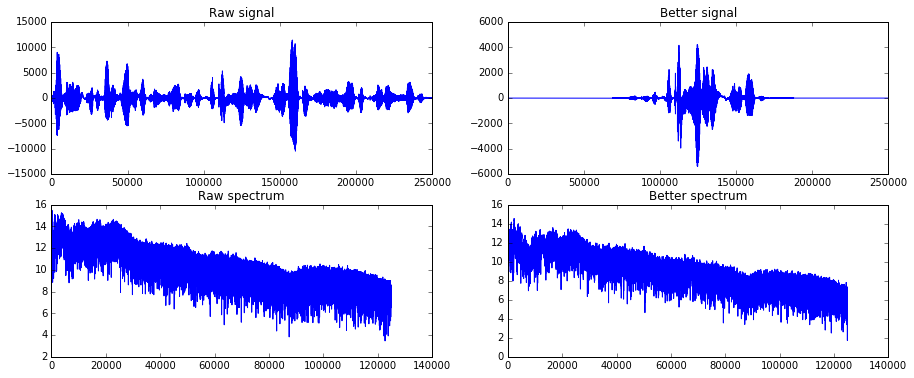

In [3]:
def KaiserBetaTest(filename = CONST_TEMPLATE_FILE, beta=100):
    w, rawSignal, rawSpectrum, signal, spectrum = PrepareSignals(filename, beta)
    print("Kaiser test, beta = " + str(beta))
    fig = plt.figure(figsize=(15, 6), dpi=80)   
    fig.add_subplot(221)
    plt.plot(rawSignal)
    plt.title("Raw signal");

    fig.add_subplot(222)
    plt.plot(signal)
    plt.title("Better signal")

    fig.add_subplot(223)
    plt.plot(rawSpectrum)
    plt.title("Raw spectrum")

    fig.add_subplot(224)
    plt.plot(spectrum)
    plt.title("Better spectrum")

#add , __manual=True to show execute button
interact(KaiserBetaTest, beta=FloatSlider(min=50, max=500, step=10, continuous_update=False), filename="../data/006_K.wav")

# Autocorellation 3/10

In [4]:
#no idea what it returns
def Autocorrelation(signal):
    result = np.correlate(signal, signal)
#     return result[result.size/2:]

In [5]:
def AutocorrelationTest(filename = CONST_TEMPLATE_FILE):
    print("Autocorrelation test.")
    w, rawSignal, rawSpectrum, signal, spectrum = PrepareSignals(filename, 100)
    print(Autocorrelation(rawSpectrum))

interact(AutocorrelationTest, filename=CONST_TEMPLATE_FILE)

Autocorrelation test.
None


<function __main__.AutocorrelationTest>

# Our best program (HPS)
The voiced speech of a typical adult male will have a fundamental frequency from 85 to 180 Hz, and that of a typical adult female from 165 to 255 Hz.

In [71]:
CONST_FEMALE_MALE_FREQ_THRESHOLD = 130 #171.25 #172.25 #130
CONST_MIN_FREQ = 75.0 #85
CONST_MAX_FREQ = 290.0 #255

def OurProgram(fmFreqThreshold, minFreq, maxFreq, beta, fileName):
    try:
        w, signal = scipy.io.wavfile.read(fileName)
    except:
#         print("Cant open file: \"" + fileName + "\"")
        if random.randint(0, 1):
            return "K"
        else:
            return "M"
    else:
        w, rawSignal, rawSpectrum, signal, spectrum = PrepareSignals(fileName, beta)
        samplesCount = len(rawSignal)
        time = samplesCount / w;
        
#         timeAxis = np.linspace(0, samplesCount, samplesCount)
#         timeAxis = [(sample/w) for sample in timeAxis]
#         fig = plt.figure(figsize=(15, 6), dpi=80)   
#         fig.add_subplot(221)
#         plt.plot(timeAxis, rawSignal)
        
        f = w*np.linspace(0, int(samplesCount/2+1), samplesCount/2+1, 0)/samplesCount
               
        #HPS
        spectrumCopy = np.array(spectrum)
        for decStep in np.arange(2, 10):
            decimateStep = decimate(spectrum, int(decStep))
            spectrumCopy[:len(decimateStep)] += decimateStep

        #FIND PITCH
        minFreqs = minFreq*time
        maxFreqs = maxFreq*time
        pitch = f[int(minFreqs):int(maxFreqs)][spectrumCopy[int(minFreqs):int(maxFreqs)].argmax()]
        
        
        
#         fig.add_subplot(222)
#         plt.plot(f[minFreqs:maxFreqs], spectrum[minFreqs:maxFreqs])
#         plt.plot(f[minFreqs:maxFreqs], rawSpectrum[minFreqs:maxFreqs])
        
#         fig.add_subplot(223)
#         plt.plot(f, spectrum)
#         plt.plot(f, rawSpectrum)
        
#         print(fileName + ": " + str(pitch))
        if pitch > fmFreqThreshold:
            return "K"
        else:
            return "M"

# interact(OurProgram, fmFreqThreshold=IntSlider(min=100, max=200, step=5, continuous_update=False),
#          minFreq=IntSlider(min=30, max=95, step=5, continuous_update=False),
#          maxFreq=IntSlider(min=185, max=300, step=5, continuous_update=False),
#          beta=IntSlider(min=10, max=500, step=10, continuous_update=False), fileName=CONST_TEMPLATE_FILE)

# Easy way

In [70]:
def MySuperEasyProgram(minMale, maxMale, minFemale, maxFemale, useRaw, fileName):
    try:
        w, signal = scipy.io.wavfile.read(fileName)
    except:
#         print("Cant open file: \"" + fileName + "\"")
        if random.randint(0, 1):
            return "K"
        else:
            return "M"
    else:
        w, rawSignal, rawSpectrum, signal, spectrum = PrepareSignals(fileName, 100)
        if useRaw:
            spectrum=rawSpectrum
        samplesCount = len(signal)
        time = samplesCount / w;        
        
        maleSum = 0;
        femaleSum = 0;
        for maleFreqs in np.arange(85*time, 180*time):
            maleSum += spectrum[int(maleFreqs)]
        for femaleFreqs in np.arange(165*time, 255*time):
            femaleSum += spectrum[int(femaleFreqs)]
        
        
        if femaleSum > maleSum:
            return "K"
        else:
            return "M"

# Tests

In [61]:
%%time
OurProgram(130, 50, 270, 100, CONST_TEMPLATE_FILE);

CPU times: user 992 ms, sys: 4 ms, total: 996 ms
Wall time: 997 ms


/home/wiekonek/.local/lib/python3.4/site-packages/ipykernel/__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


'M'

In [65]:
%%time
MySuperEasyProgram(85, 180, 165, 255, True, CONST_TEMPLATE_FILE)

CPU times: user 932 ms, sys: 0 ns, total: 932 ms
Wall time: 933 ms


/home/wiekonek/.local/lib/python3.4/site-packages/ipykernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/wiekonek/.local/lib/python3.4/site-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


'K'

In [75]:
import os, re;

def PrintResult(fileName, sex, isOk):
    isOkValue = "NO";
    if isOk:
        isOkValue = "YES";
    print("File name: \"" + fileName + "\", Result: \"" + sex + "\", IsOK: \"" + isOkValue + "\"")

def OurProgramAccuracy(fmFreqThreshold, minFreq, maxFreq, beta):
    okCount = 0
    filenames = os.listdir('../data')
    for filename in filenames:
        sex = OurProgram(fmFreqThreshold, minFreq, maxFreq, beta, '../data/' + filename)
        if re.search('([KM])\.wav', filename).group(1) == sex:
            okCount += 1
#             PrintResult(filename, sex, True)
#         else:
#             PrintResult(filename, sex, False)
        print('.', end='')
    
    print("")            
    print("Accuracy = " + str(okCount/len(filenames) * 100) + " %")
    
def MyProgramAccuracy(minMale, maxMale, minFemale, maxFemale, useRaw):
    okCount = 0
    filenames = os.listdir('../data')
    for filename in filenames:
        sex = MySuperEasyProgram(minMale, maxMale, minFemale, maxFemale, useRaw, '../data/' + filename)
        if re.search('([KM])\.wav', filename).group(1) == sex:
            okCount += 1
#             PrintResult(filename, sex, True)
#         else:
#             PrintResult(filename, sex, False)
        print('.', end='')
    
    print("")
    print("Accuracy = " + str(okCount/len(filenames) * 100) + " %")

In [73]:
%%time
OurProgramAccuracy(130, 50, 270, 100)

.................

/usr/lib/python3/dist-packages/scipy/io/wavfile.py:42: WavFileWarning: Unknown wave file format
  warnings.warn("Unknown wave file format", WavFileWarning)
/usr/lib/python3/dist-packages/scipy/io/wavfile.py:172: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


..........................................................................
Accuracy = 70.32967032967034 %
CPU times: user 1min 39s, sys: 80 ms, total: 1min 39s
Wall time: 1min 39s


/home/wiekonek/.local/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


### Polecam

In [76]:
%%time
MyProgramAccuracy(85, 180, 165, 255, True)

.................

/usr/lib/python3/dist-packages/scipy/io/wavfile.py:42: WavFileWarning: Unknown wave file format
  warnings.warn("Unknown wave file format", WavFileWarning)
/usr/lib/python3/dist-packages/scipy/io/wavfile.py:172: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


..........................................................................
Accuracy = 87.91208791208791 %
CPU times: user 1min 36s, sys: 112 ms, total: 1min 36s
Wall time: 1min 36s


/home/wiekonek/.local/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log
